## Imports

In [1]:
import os
os.environ['R_HOME'] = 'C:/Users/timot/miniforge3/envs/525_2025/lib/R'
import re
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd

%load_ext rpy2.ipython
import pyarrow.dataset as ds
import pyarrow as pa
import pandas as pd
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

c:\Users\timot\miniforge3\envs\525_2025\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


## 1) Downloading the Data

In [2]:
# We are downloading to the data/ folder in this repository

%mkdir data
# %cd data/

A subdirectory or file data already exists.


In [3]:
# Setting metadata for download
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "data/"

In [4]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'mimetype': 'image/png'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'mimetype': 'text/plain'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'mimetype': 'text/x-python'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://n

In [5]:
%%time

# Download the file "data.zip"
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: total: 2.28 s
Wall time: 1min 19s


In [6]:
%%time

# Unzip the CSVs from the zip file
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: total: 13.4 s
Wall time: 33.3 s


In [7]:
# View files that were extracted
%ls -ltr data

 Volume in drive C is OS
 Volume Serial Number is 1837-1226

 Directory of c:\Users\timot\OneDrive - UBC\Documents\Semester 2\Block 6\525\rainfall-predictor


 Directory of c:\Users\timot\OneDrive - UBC\Documents\Semester 2\Block 6\525\rainfall-predictor\data

29/03/2025  11:39 am    <DIR>          .
27/03/2025  12:33 am    <DIR>          ..
25/03/2025  02:34 pm    <DIR>          __MACOSX
29/03/2025  11:39 am       127,613,760 ACCESS-CM2_daily_rainfall_NSW.csv
29/03/2025  11:39 am       114,707,410 ACCESS-ESM1-5_daily_rainfall_NSW.csv
29/03/2025  11:39 am        94,960,113 AWI-ESM-1-1-LR_daily_rainfall_NSW.csv
29/03/2025  11:39 am       294,260,911 BCC-CSM2-MR_daily_rainfall_NSW.csv
29/03/2025  11:39 am        55,224,437 BCC-ESM1_daily_rainfall_NSW.csv
29/03/2025  11:39 am        46,286,371 CanESM5_daily_rainfall_NSW.csv
29/03/2025  11:39 am       330,360,682 CMCC-CM2-HR4_daily_rainfall_NSW.csv
29/03/2025  11:39 am       328,787,320 CMCC-CM2-SR5_daily_rainfall_NSW.csv
29/03/2025  11:39

File Not Found


## 2) Combining CSVs

In [8]:
%%time
# Remove un-needed file
remove_file = "data//observed_daily_rainfall_SYD.csv"

if os.path.exists(remove_file):
    os.remove(remove_file)
    print(f"{remove_file} deleted successfully.")
else:
    print(f"{remove_file} not found.")
    
# Combine
use_cols = ["time", "lat_min", "lat_max", "lon_min", "lon_max", "rain (mm/day)"]
files = glob.glob('data/*.csv')
df = pd.concat(pd.read_csv(file, index_col=0, usecols=use_cols)
                .assign(model=re.findall(r"data\\([^_]*)", file)[0])    # Extra data\ to account for Windows file scheme
                for file in files
              )
df.to_csv("data/combined_data.csv")

data//observed_daily_rainfall_SYD.csv deleted successfully.
CPU times: total: 13min 23s
Wall time: 14min 20s


**Time Comparison with Lab Members**

| preferred lab partner(s) | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Timothy Singh | Windows 11 Home | 16GB | Intel i7-11800H | Yes |  14 minutes |
| Benjamin Frizzell*  | MacOS  | 8GB | Intel i5 Duo Core |  Yes | 3 minutes  |
| Stephanie Ta   | Windows 10  | 16GB  | Intel i7-1065G7  |  Yes  | 4 minutes |
| Meagan Gardener   |  MacOS  |  16GB  | Apple M3   |  Yes  | 3 minutes |

*loaded with a parquet file

From the comparison table it is seen that his task took much longer for me when compared with the members of my group. This was the lowest result of several attempts, which gave times of 17 minutes, 22 minutes, 31 minutes and 14 minutes. Some troubleshooting was attempted, by closing background programs, restarting my device and even varying between VS Code and JupyterLab (in browser). Note that VS Code yielded better times than JupyterLab in the browser. It was also noticed when combining RAM usage increased a bit, but peaked around 85%. The reason for such deviation in time could possibly be explained by the difference in OS, since I was the only member using Windows 11. Additionally, there were updates that were pending install, which could have potentially affected this. 

From the comparison, it appeared as though devices running MacOS performed this best in this task. Even though one member loaded with a parquet file, their device had 8GB RAM, and still performed better than the Windows 10 and Windows 11 devices. The member using Windows 10 still had a longer time than the member used MacOS with 8GB RAM. This further demonstrates that the Windows OS possibly takes more resources when compared to MacOS.

## 3) Load the combined CSV to memory and perform a simple EDA


Here, we will load the data in chunks, getting rid of the `lat_min`, `lat_max`, `lon_min` and `lon_max` columns, and convert values in the `rain (mm/day)` column to `float32`

In [9]:
%%time

# Load only "time". "model" and "rain (mm/day) columns, with 
# "time" as datetime, "model" as string and "rain (mm/day) as float32
# Also read as chunks, and perform EDA on each chunk

usecols = ["time", "rain (mm/day)", "model"]
dtypes = {"time": "string",
          "rain (mm/day)": "float32",
          "model": "string"}
          
value_counts = pd.Series(dtype=int)
rainfall_total = pd.Series(dtype=float)

for chunk in pd.read_csv("data/combined_data.csv",
    usecols = usecols,
    dtype = dtypes,
    parse_dates=["time"] ,
    chunksize=500_000
):
    value_counts = value_counts.add(chunk["model"].value_counts(), fill_value=0)
    rainfall_total = rainfall_total.add(chunk.groupby("model")["rain (mm/day)"].sum(), fill_value=0)

CPU times: total: 5min 50s
Wall time: 6min 3s


In [10]:
eda_summary = pd.DataFrame({
    "model": rainfall_total.index,
    "rainfall_total": rainfall_total.values,
    "values_count": value_counts.values
    }
)

eda_summary

,model,rainfall_total,values_count
0,ACCESS-CM2,3.454034e+06,1932840.0
1,ACCESS-ESM1-5,3.571729e+06,1610700.0
2,AWI-ESM-1-1-LR,1.958036e+06,966420.0
3,BCC-CSM2-MR,5.924474e+06,3035340.0
4,BCC-ESM1,9.994724e+05,551880.0
5,CMCC-CM2-HR4,8.071704e+06,3541230.0
6,CMCC-CM2-SR5,8.440127e+06,3541230.0
7,CMCC-ESM2,8.024869e+06,3541230.0
8,CanESM5,1.045442e+06,551880.0
9,EC-Earth3-Veg-LR,4.605362e+06,3037320.0


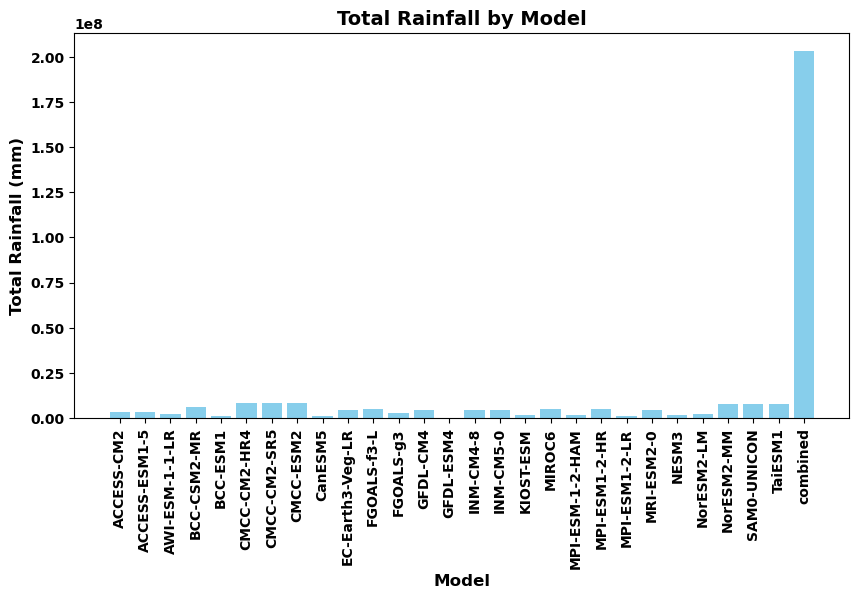

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(eda_summary["model"], eda_summary["rainfall_total"], color="skyblue")

# Titles and labels
plt.title("Total Rainfall by Model", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Total Rainfall (mm)", fontsize=12)
plt.xticks(rotation=90)  

plt.show();


**Time Comparison with Lab Members**

| preferred lab partner(s) | Operating System | RAM | Processor | Is SSD | Time taken | Methods used for Loading |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|:---------------------------:|
| Timothy Singh | Windows 11 Home | 16GB | Intel i7-11800H | Yes |  6 minutes | Only relevant columns, data type conversion, chunk loading |
| Benjamin Frizzell  | MacOS  | 8GB | Intel i5 Duo Core |  Yes | 1 minute  | Only relevant columns, data type conversion, parquet file saving |
| Stephanie Ta   | Windows 10  | 16GB  | Intel i7-1065G7  |  Yes  | 1 minute | Only relevant columns, data type conversion | 
| Meagan Gardener   |  MacOS  |  16GB  | Apple M3   |  Yes  | 20 seconds | Only relevant columns, data type conversion |


Similar to the results in Question 2, my device yielded the longest time for this operation when compared to my group members. Other than myself, no other member performmed "chunk loading", but the times are not an accurate comparison due to the unusually long times on my device. This was attempted with a chunk size of 1_000_000, then 500_000, of which the latter gave slightly better performance (~25 seconds faster). Other than OS, a possible cause of this could be that multiple cores of the CPU not being utilized for this task, resulting in slower times. Overall, the comparison shows that the Apple M3 CPU yields the best performances among the difference CPUs, along with the MacOS operating systems also performing the best among operating systems.

## 4) Perform a simple EDA in R

In [18]:
# Since we already have the entire dataset loaded in memory from 
# as a dataframe (df), we can use pyarrow to convert it into a 
# table and subsequently pyra.

filepathcsv = "data/combined_data.csv"
dataset = ds.dataset(filepathcsv, format="csv")
table = dataset.to_table()
%time r_table = pyra.converter.py2rpy(table)

CPU times: total: 188 ms
Wall time: 530 ms


              model rainfall_total values_count
1        ACCESS-CM2      3454033.5      1932840
2     ACCESS-ESM1-5      3571729.0      1610700
3    AWI-ESM-1-1-LR      1958035.9       966420
4       BCC-CSM2-MR      5924474.2      3035340
5          BCC-ESM1       999472.4       551880
6           CanESM5      1045441.6       551880
7      CMCC-CM2-HR4      8071704.2      3541230
8      CMCC-CM2-SR5      8440126.9      3541230
9         CMCC-ESM2      8024868.6      3541230
10         combined    203046194.9     94388832
11 EC-Earth3-Veg-LR      4605362.0      3037320
12      FGOALS-f3-L      5239002.4      3219300
13        FGOALS-g3      2776864.5      1287720
14         GFDL-CM4      4553652.5      3219300
15        GFDL-ESM4            0.0      3219300
16        INM-CM4-8      4525471.1      1609650
17        INM-CM5-0      4296175.4      1609650
18        KIOST-ESM      1419521.5      1287720
19           MIROC6      4766511.2      2070900
20  MPI-ESM-1-2-HAM      1556631.6      

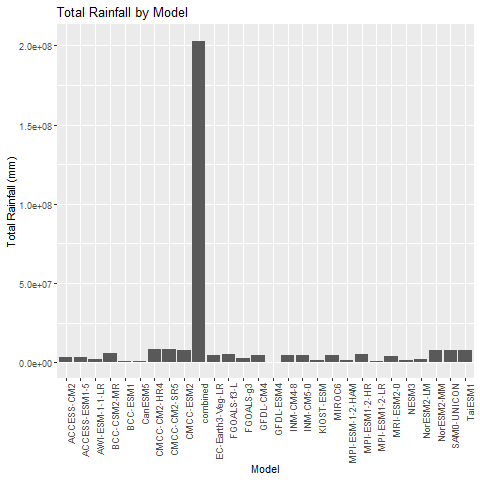

In [19]:
%%R -i r_table

# Load libraries
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))

# Perform data wrangling to do EDA. Just as before, we are getting
# the total rainfall and value counts per model
result <- r_table |>
    select(time, model, `rain (mm/day)`) |>
    group_by(model) |>
    summarize(rainfall_total = sum(`rain (mm/day)`, na.rm = TRUE),
             values_count = n())
print(as.data.frame(result))

# Make a similar plot as in Python
plot <- as.data.frame(result) |>
    ggplot(aes(x = model, y = rainfall_total)) +
    geom_bar(stat = "identity") +
    ggtitle("Total Rainfall by Model") +
    xlab("Model") +
    ylab("Total Rainfall (mm)") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

plot

Arrow exchange (using pyarrow) was selected as the method for transferring the entire dataframe from Python to R. Serialization refers to the process of saving an object state as a sequence of bytes so it can be saved as a file (typically a CSV). Deserialization is the opposite of serialization where these bytes are reconstructed into an object that can be used in a programming language. This method of arrow exchange simplifies the serialization/deserialization process allowing the data to be transferred directly from Python to R, without any extra overhead of reading another file into memory. Also this method supports and even abstracts chunking and parallelism, improving the efficiency of loading and transferring the data.

Another viable option could have been to use parquet file, which decreases the reading time in R, but this comes with the disadvantage of having to save an additional file to disk. This would increase the overall time, since a new file would have to be created and read into memory. To preserve the limited disk space, the arrow exchange method was used in this case. The pandas exchange method requires loading the data, and converting which is slow and less efficient.